In [1]:
from gurobipy import *
import gurobipy as gp

# type declaration
from typing import Dict, List


import pandas as pd
import numpy as np

# %load_ext nb_black
# %load_ext lab_black

In [2]:
df_distances = pd.read_csv(
    "/home/angelo/Documents/Uni/Courses/Management Science/MM_Code_repo/data/distances.csv"
)
df_pairs = pd.read_csv(
    "/home/angelo/Documents/Uni/Courses/Management Science/MM_Code_repo/data/pairs.csv"
)

#### Data Prep

In [3]:
unique_c1 = list(df_distances.city1.unique())

# possible combinations
for c in unique_c1:
    d1 = [c, c, 0]
    df_distances = df_distances.append(
        pd.Series(d1, index=["city1", "city2", "distance"]), ignore_index=True
    )

/tmp/ipykernel_26410/3893934404.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_distances = df_distances.append(
/tmp/ipykernel_26410/3893934404.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_distances = df_distances.append(
/tmp/ipykernel_26410/3893934404.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_distances = df_distances.append(
/tmp/ipykernel_26410/3893934404.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_distances = df_distances.append(
/tmp/ipykernel_26410/3893934404.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat in

In [4]:
df_pairs.loc[df_pairs.Dage == "-", "Dage"] = 99999999
df_pairs.Dage = df_pairs.Dage.astype(int)
df_pairs.loc[df_pairs.Rage == "-", "Rage"] = 99999999
df_pairs.Rage = df_pairs.Rage.astype(int)

df_pairs.loc[df_pairs.DBT == "-", "DBT"] = "NaN"
df_pairs.DBT = df_pairs.DBT.astype(str)
df_pairs.loc[df_pairs.RBT == "-", "RBT"] = "NaN"
df_pairs.RBT = df_pairs.RBT.astype(str)

In [5]:
# write the compatible bloodtypes
bloodtypes: Dict[str, int] = {
    # from A to everything
    ("A", "A"): 1,
    ("A", "B"): 0,
    ("A", "AB"): 1,
    ("A", "O"): 0,
    # from b to everything
    ("B", "A"): 0,
    ("B", "B"): 1,
    ("B", "AB"): 1,
    ("B", "O"): 0,
    # from AB to everything
    ("AB", "A"): 0,
    ("AB", "B"): 0,
    ("AB", "AB"): 1,
    ("AB", "O"): 0,
    # from O to everything
    ("O", "A"): 1,
    ("O", "B"): 1,
    ("O", "AB"): 1,
    ("O", "O"): 1,
    # missing blootypes
    ("NaN", "A"): 0,
    ("NaN", "B"): 0,
    ("NaN", "AB"): 0,
    ("NaN", "O"): 0,
    ("A", "NaN"): 0,
    ("B", "NaN"): 0,
    ("AB", "NaN"): 0,
    ("O", "NaN"): 0,
}

In [6]:
# change the order of the df to be more intuitive
RBT = df_pairs.loc[:, "RBT"]
DBT = df_pairs.loc[:, "DBT"]

# drop column
df_pairs.drop(columns=["RBT", "DBT"], axis=1, inplace=True)

# add them back
df_pairs["DBT"] = DBT
df_pairs["RBT"] = RBT

In [7]:
for i, r in df_pairs.iterrows():
    if (
        (df_pairs.iloc[i].type == "pair")
        & (
            abs(df_pairs.iloc[i].Rage.astype(int) - df_pairs.iloc[i].Dage.astype(int))
            <= 10
        )
        & (bloodtypes[(df_pairs.iloc[i].DBT, df_pairs.iloc[i].RBT)] == 1)
    ) == True:
        df_pairs.loc[i, "C"] = 1
    else:
        df_pairs.loc[i, "C"] = 0

### create arcs

In [8]:
def pos_city_sublist(location_):
    """_summary_

    Args:
        location_ (_type_): _description_

    Returns:
        _type_: _description_
    """
    return list(
        df_distances[
            (df_distances.city1.astype(str) == location_)
            & (df_distances.distance <= 300)
        ].city2.values
    )


def blood_types_rbt(RBT_):
    """_summary_

    Args:
        RBT_ (_type_): _description_

    Returns:
        _type_: _description_
    """
    valid_bloodtypes_receiver_tmp = []
    for k, v in bloodtypes.items():
        if (k[1] == RBT_) & (v == 1):
            valid_bloodtypes_receiver_tmp.append(k[0])

    return valid_bloodtypes_receiver_tmp


def blood_types_dbt(DBT_):
    """_summary_

    Args:
        DBT_ (_type_): _description_

    Returns:
        _type_: _description_
    """
    valid_bloodtypes_donor_tmp = []
    for k, v in bloodtypes.items():
        if (k[0] == DBT_) & (v == 1):
            valid_bloodtypes_donor_tmp.append(k[1])

    return valid_bloodtypes_donor_tmp

In [9]:
arcs_: Dict[tuple, list] = {}

for i, r in df_pairs.iterrows():
    id_ = df_pairs.iloc[i].ID
    type_ = df_pairs.iloc[i].type
    Rage_ = df_pairs.iloc[i].Rage
    Dage_ = df_pairs.iloc[i].Dage
    location_ = df_pairs.iloc[i].Location
    compatible_ = df_pairs.iloc[i].C
    RBT_ = df_pairs.iloc[i].RBT
    DBT_ = df_pairs.iloc[i].DBT

    # pairs
    if type_ == "pair":

        # create a subset of cities that are valid
        possible_cities1 = pos_city_sublist(location_)

        # for receivers, create a donor vloodtype list that contains all the blood types that are compartible
        valid_bloodtypes_receiver = blood_types_rbt(RBT_)

        # same but inverted the donor blood types
        valid_bloodtypes_donor = blood_types_dbt(DBT_)

        arcs_[("pair_receiver", id_)] = list(
            df_pairs[
                (df_pairs.Location.isin(possible_cities1))
                & (abs(df_pairs.Dage - Rage_) <= 10)
                & (df_pairs.DBT.isin(valid_bloodtypes_receiver))
            ].ID.values
        )

        arcs_[("pair_donor", id_)] = list(
            df_pairs[
                (df_pairs.Location.isin(possible_cities1))
                & (abs(df_pairs.Rage - Dage_) <= 10)
                & (df_pairs.RBT.isin(valid_bloodtypes_donor))
            ].ID.values
        )

    elif type_ == "receiver":
        # grap the city and only select those rows in "city1" where  the df_distances.city.astye(str) == location_
        # create a subset of cities that are valid
        possible_cities1 = pos_city_sublist(location_)

        # for receivers, create a donor vloodtype list that contains all the blood types that are compartible
        valid_bloodtypes_receiver = blood_types_rbt(RBT_)

        arcs_[("receiver", id_)] = list(
            df_pairs[
                (df_pairs.Location.isin(possible_cities1))
                & (abs(df_pairs.Dage - Rage_) <= 10)
                & (df_pairs.DBT.isin(valid_bloodtypes_receiver))
            ].ID.values
        )

    elif type_ == "donor":
        # grap the city and only select those rows in "city1" where  the df_distances.city.astye(str) == location_
        # create a subset of cities that are valid
        possible_cities1 = pos_city_sublist(location_)

        # same but inverted the donor blood types
        valid_bloodtypes_donor = blood_types_dbt(DBT_)

        arcs_[("donor", id_)] = list(
            df_pairs[
                (df_pairs.Location.isin(possible_cities1))
                & (abs(df_pairs.Rage - Dage_) <= 10)
                & (df_pairs.RBT.isin(valid_bloodtypes_donor))
            ].ID.values
        )

    else:
        print("warning")
        break

In [10]:
arcs_l = []
for k, v in arcs_.items():
    for i in range(len(v)):
        if k[0] in ["donor", "pair_donor"]:
            arcs_l.append((k[1], v[i]))

## Da model 

In [11]:
df_arcs = pd.DataFrame(arcs_l, columns =['donor', 'receiver']).reset_index()

In [12]:
donors_unique = []
receiver_unique = []
for possib in arcs_l:
    donors_unique.append(possib[0])
    receiver_unique.append(possib[1])
donors_unique = list(set(donors_unique))
receiver_unique = list(set(receiver_unique))

In [13]:
pair=df_pairs[df_pairs.type=="pair"].reset_index(drop=True)[["ID","RBT","DBT","Rage","Dage","Location"]]

In [14]:
model.addConstrs(((gp.quicksum(x[i,j] for i in list(df_arcs.loc[df_arcs["receiver"]==j].donor))<= 1) for j in receiver_unique), name="demand_r")

NameError: name 'model' is not defined

In [15]:
for donor_or_pair_id in receiver_unique:
    lhs = 0
    for pairing in arcs_l:
        if pairing[0] == donor_or_pair_id:
            lhs += x[pairing]
    model.addConstr(lhs <= 1)

NameError: name 'model' is not defined

In [16]:
arc_donor = {}
for arc_k, arc_v in arcs_.items():
    if arc_k[1] in donors_unique:
        arc_donor[arc_k[1]] = arc_v
        
arc_receiver = {}
for arc_k, arc_v in arcs_.items():
    if arc_k[1] in donors_unique:
        arc_receiver[arc_k[1]] = arc_v

In [17]:
model.addConstrs(((gp.quicksum(x[i,j] for j in list(df_arcs.loc[df_arcs["donor"]==i].receiver))) <= 
                 (gp.quicksum(x[j,i] for j in list(df_arcs.loc[df_arcs["receiver"]==i].donor))) for i in pair.ID),name="pair_dr")

pair=df_pairs[df_pairs.type=="pair"].reset_index(drop=True)[["ID","RBT","DBT","Rage","Dage","Location"]]


NameError: name 'model' is not defined

In [18]:
pair=df_pairs[df_pairs.type=="pair"].reset_index(drop=True)[["ID","RBT","DBT","Rage","Dage","Location"]]


In [19]:
### Solving the model ###
# Initialize empty model and set model sense
model = gp.Model()
model.ModelSense = gp.GRB.MAXIMIZE


index=df_arcs.index

# Define variables
x=model.addVars(donors_unique,receiver_unique, vtype=gp.GRB.BINARY, name="x")

# Set objective function
model.setObjective(gp.quicksum(x[(i[0],i[1])] for i in arcs_l))

# Add constraints
# for each donor there can only be in total one transfer for all elegible receivers (only one transfer)
for donor_or_pair_id in donors_unique:
    lhs = 0
    for pairing in arcs_l:
        if pairing[0] == donor_or_pair_id:
            lhs += x[pairing]
    model.addConstr(lhs <= 1, name="supply_d")

# for each receiver there can only be in total one transfer for all elegible donor (only one transfer)
for donor_or_pair_id in receiver_unique:
    lhs = 0
    for pairing in arcs_l:
        if pairing[1] == donor_or_pair_id:
            lhs += x[pairing]
    model.addConstr(lhs <= 1, name="demand_r")


# for all pairs there can only be one receiver if there is one donor if they are used to be transfered to some extend
model.addConstrs(((gp.quicksum(x[i,j] for j in list(df_arcs.loc[df_arcs["donor"]==i].receiver))) <= 
                 (gp.quicksum(x[j,i] for j in list(df_arcs.loc[df_arcs["receiver"]==i].donor))) for i in pair.ID),name="pair_dr")

# Optimize the model and print results    
model.optimize()

if not model.status == gp.GRB.OPTIMAL:
     print("Something went wrong...")
        
### Print the result of optimimization ###      
print("Optimal value: ", model.objval)
model.printAttr(["X"])

Set parameter Username
Academic license - for non-commercial use only - expires 2023-11-10
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 369 rows, 17762 columns and 2932 nonzeros
Model fingerprint: 0xb1892603
Variable types: 0 continuous, 17762 integer (17762 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 52.0000000
Found heuristic solution: objective 57.0000000
Presolve removed 182 rows and 17077 columns
Presolve time: 0.03s
Presolved: 187 rows, 685 columns, 2200 nonzeros
Found heuristic solution: objective 79.0000000
Variable types: 0 continuous, 685 integer (685 binary)

Root relaxation: objective 9.400000e+01, 168 iterat

### B

In [20]:
output_dict = {}
for i_x, variable_o in zip(x, model.getVars()) :
    output_dict[i_x] = variable_o.x

output_dict_success = {}
for k,v  in output_dict.items():
    if v == 1:
        output_dict_success[k] = v


In [21]:
receiver_id = []
for i in output_dict_success:
    receiver_id.append(i[1])

In [22]:
pair_id_final_received = []
receiver_id_final_received = []
for i in receiver_id:
    if i in list(df_pairs[df_pairs.type == "pair"].ID.values):
        pair_id_final_received.append(i)
    else:
        receiver_id_final_received.append(i)

    


In [23]:
print(len(receiver_id_final_received) + len(pair_id_final_received))
print([i for i in receiver_id_final_received if i in pair_id_final_received])

94
[]


In [24]:
print("receiver receiving", str(len(receiver_id_final_received)/len(list(df_pairs[df_pairs.type == "receiver"].ID))))
print("pairs receiving", str(len(pair_id_final_received)/len(list(df_pairs[df_pairs.type == "pair"].ID))))

receiver receiving 0.2
pairs receiving 0.8125


### C

In [25]:
paird_selection = []
for i in output_dict_success:
    if i[0] == i[1]:
        paird_selection.append(i)
1 - len(paird_selection)/len(output_dict_success)


0.851063829787234

In [26]:
donor_dontated = []
for i in output_dict_success:
    if i[0] in list((df_pairs[df_pairs.type == "donor"]).ID.values):
        donor_dontated.append(i)

len(donor_dontated) / len(list((df_pairs[df_pairs.type == "donor"]).ID.values))

0.875

### D

In [27]:
len(df_pairs[(df_pairs.ID.isin(pair_id_final_received))&(df_pairs.DBT!=df_pairs.RBT)].ID)/len(pair_id_final_received)

0.6025641025641025

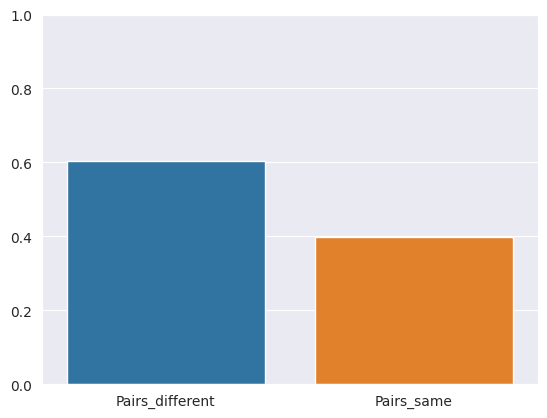

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')

x = ['Pairs_different', 'Pairs_same']
y = [len(df_pairs[(df_pairs.ID.isin(pair_id_final_received))&(df_pairs.DBT!=df_pairs.RBT)].ID)/len(pair_id_final_received),
1 - len(df_pairs[(df_pairs.ID.isin(pair_id_final_received))&(df_pairs.DBT!=df_pairs.RBT)].ID)/len(pair_id_final_received)]

plt.ylim(0, 1)
sns.barplot(x = x, y = y)
plt.show()

#### E

In [29]:
df_pairs_that_received_by_city = df_pairs[df_pairs.ID.isin(pair_id_final_received)].groupby(by =["Location"]).agg({"ID":"count"})
df_NOT_pairs_that_received_by_city = df_pairs[~(df_pairs.ID.isin(pair_id_final_received))].groupby(by =["Location"]).agg({"ID":"count"})
df_merged = pd.merge(left = df_pairs_that_received_by_city, right = df_NOT_pairs_that_received_by_city, left_index = True, right_index = True, how = "inner")

df_merged['total_pairs'] = df_merged["ID_x"] + df_merged["ID_y"]
df_merged['proportion'] = df_merged["ID_x"] / df_merged["total_pairs"]

In [30]:
df_merged = pd.merge(left = df_pairs_that_received_by_city, right = df_NOT_pairs_that_received_by_city, left_index = True, right_index = True, how = "inner")

df_merged['total_pairs'] = df_merged["ID_x"] + df_merged["ID_y"]
df_merged['proportion'] = df_merged["ID_x"] / df_merged["total_pairs"]

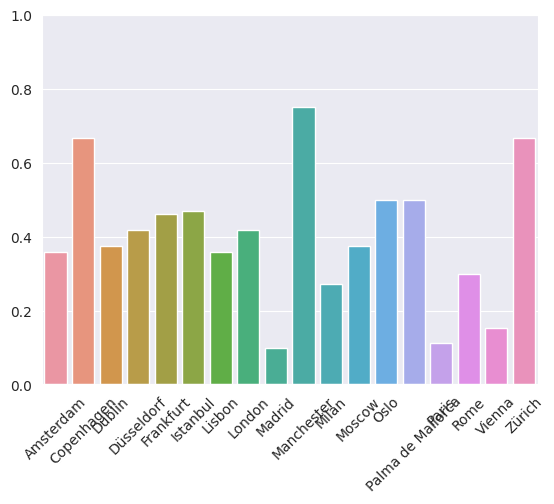

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')

x = list(df_merged.index)
y = list(df_merged.proportion)

plt.xticks(rotation=45)
plt.ylim(0, 1)
sns.barplot(x = x, y = y)
plt.show()

In [ ]:
donor=df_pairs[df_pairs.type=="donor"].reset_index(drop=True)[["ID","DBT","Dage","Location"]]
pair=df_pairs[df_pairs.type=="pair"].reset_index(drop=True)[["ID","RBT","DBT","Rage","Dage","Location"]]
receiver=df_pairs[df_pairs.type=="receiver"].reset_index(drop=True)[["ID","RBT","Rage","Location"]]

In [51]:
### Solving the model ###

# Initialize empty model and set model sense
model = gp.Model()
model.ModelSense = gp.GRB.MAXIMIZE


index=df_arcs.index

# Define variables
x=model.addVars(donors_unique,receiver_unique, vtype=gp.GRB.BINARY, name="x")


# Set objective function
model.setObjective(gp.quicksum(x[(i[0],i[1])] for i in arcs_l))


# Add constraints
# for each donor there can only be in total one transfer for all elegible receivers
model.addConstrs(((gp.quicksum(x[i,j] for j in list(df_arcs.loc[df_arcs["donor"]==i].receiver)) <= 1) for i in donors_unique), name="supply_d")


model.addConstrs(((gp.quicksum(x[i,j] for i in list(df_arcs.loc[df_arcs["receiver"]==j].donor))<= 1) for j in receiver_unique), name="demand_r")


model.addConstrs(((gp.quicksum(x[i,j] for j in list(df_arcs.loc[df_arcs["donor"]==i].receiver))) <= 
                 (gp.quicksum(x[j,i] for j in list(df_arcs.loc[df_arcs["receiver"]==i].donor))) for i in pair.ID),name="pair_dr")



# Optimize the model and print results    
model.optimize()

if not model.status == gp.GRB.OPTIMAL:
     print("Something went wrong...")
        
### Print the result of optimimization ###      
print("Optimal value: ", model.objval)
model.printAttr(["X"])

Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 369 rows, 17762 columns and 2932 nonzeros
Model fingerprint: 0xb1892603
Variable types: 0 continuous, 17762 integer (17762 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 52.0000000
Found heuristic solution: objective 57.0000000
Presolve removed 182 rows and 17077 columns
Presolve time: 0.02s
Presolved: 187 rows, 685 columns, 2200 nonzeros
Found heuristic solution: objective 79.0000000
Variable types: 0 continuous, 685 integer (685 binary)

Root relaxation: objective 9.400000e+01, 168 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bou

In [18]:
df_arcs

,index,donor,receiver
0,0,4,30
1,1,4,47
2,2,4,101
3,3,4,138
4,4,4,183
...,...,...,...
891,891,199,80
892,892,199,91
893,893,199,147
894,894,199,199


In [17]:
df_arcs._get_value(i,"donor")

4

In [52]:
model.write("problem.lp")
with open("problem.lp") as f:
    print(f.read())

\ LP format - for model browsing. Use MPS format to capture full model detail.
Maximize
  x[2,1] + x[2,2] + x[2,3] + x[2,4] + x[2,5] + x[2,6] + x[2,7] + x[2,8]
   + x[2,9] + x[2,10] + x[2,11] + x[2,12] + x[2,15] + x[2,16] + x[2,18]
   + x[2,19] + x[2,20] + x[2,21] + x[2,22] + x[2,23] + x[2,24] + x[2,25]
   + x[2,26] + x[2,27] + x[2,28] + x[2,29] + x[2,30] + x[2,32] + x[2,33]
   + x[2,34] + x[2,35] + x[2,37] + x[2,38] + x[2,39] + x[2,40] + x[2,42]
   + x[2,43] + x[2,44] + x[2,45] + x[2,46] + x[2,47] + x[2,48] + x[2,49]
   + x[2,50] + x[2,51] + x[2,52] + x[2,53] + x[2,54] + x[2,56] + x[2,57]
   + x[2,58] + x[2,59] + x[2,60] + x[2,62] + x[2,65] + x[2,66] + x[2,69]
   + x[2,70] + x[2,71] + x[2,72] + x[2,73] + x[2,74] + x[2,75] + x[2,76]
   + x[2,77] + x[2,78] + x[2,79] + x[2,80] + x[2,81] + x[2,82] + x[2,83]
   + x[2,84] + x[2,85] + x[2,86] + x[2,87] + x[2,88] + x[2,89] + x[2,90]
   + x[2,91] + x[2,92] + x[2,93] + x[2,94] + x[2,96] + x[2,97] + x[2,98]
   + x[2,99] + x[2,100] + x[2,101] + x